In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import config
import os
from datetime import datetime
import time

import numpy as np

In [2]:
df = pd.read_csv(config.DATA_FILE, parse_dates=['date'])
df['date'] = pd.to_datetime(df.date)
df['date'] = df['date'].dt.strftime('%d/%m/%y')
# df = df.groupby(['date', 'lesson'], sort=False)
# df = df.set_index('date')

In [3]:
df.head()

,date,lesson,views,name
0,17/07/20,1-0,8472,Welcome to Udacity
1,17/07/20,1-1,4889,Why Machine Learning?
2,17/07/20,1-2,4460,Course Overview
3,17/07/20,2-0,4575,Lesson Overview
4,17/07/20,2-1,4095,What is Machine Learning?


In [4]:
lessonDf = df[df['lesson'] == '1-0']

In [5]:
lessonDf = lessonDf.set_index('date')

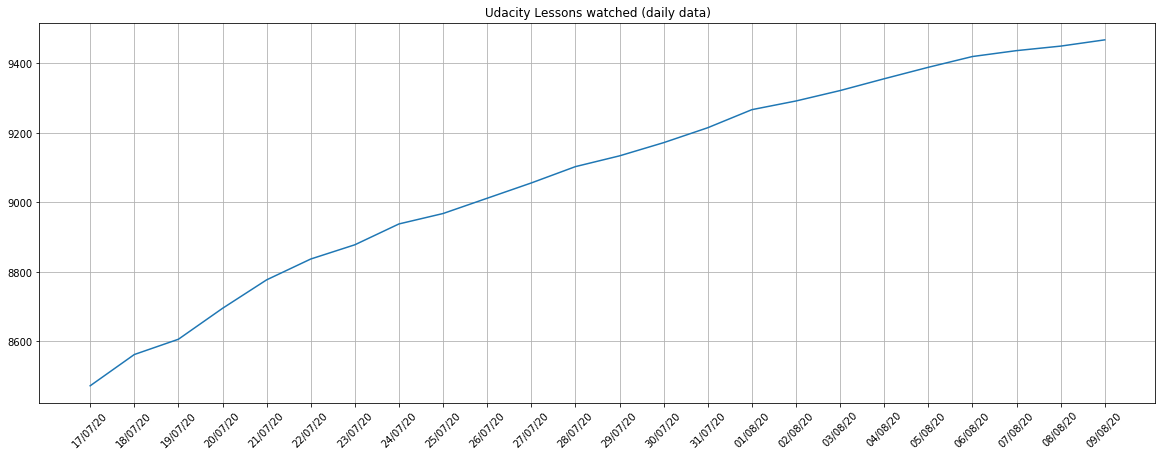

In [6]:
plt.figure(figsize=(20, 7))
plt.plot(lessonDf.views)
plt.xticks(rotation=45)
plt.title('Udacity Lessons watched (daily data)')
plt.grid(True)
plt.show()

In [7]:

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 2. Move, smoothe, evaluate

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like  𝑦̂ 𝑡=𝑦𝑡−1  (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its  𝑘  previous values. Therefore, we will use the moving average.


In [8]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(lessonDf['views'], 1) # prediction for the last observed day (past 24 hours)

9468.0

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with DataFrame.rolling(window).mean(). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [9]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xticks(rotation=45)

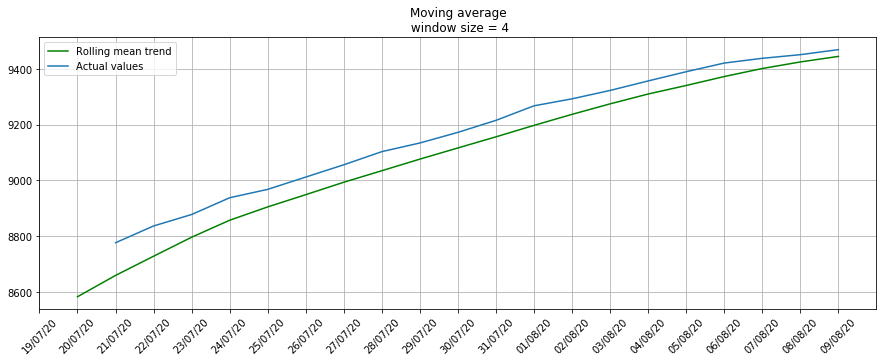

In [10]:
plotMovingAverage(lessonDf['views'], 4) 